In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display


import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [3]:
notes = np.array(['A','G#','G','F#','F','E','D#','D','C#','C','B','A#'])
print('Notes:', notes)

Notes: ['A' 'G#' 'G' 'F#' 'F' 'E' 'D#' 'D' 'C#' 'C' 'B' 'A#']


#### Предварительная проверка файлов на соответствие размеру окна

In [4]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
    # чтобы это работало на графике TensorFlow.
    return parts[-2]

def get_waveform_and_label_check(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label, file_path

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
files_ds = tf.data.Dataset.from_tensor_slices(filenames)
output_ds = files_ds.map(get_waveform_and_label_check, num_parallel_calls=AUTOTUNE)

In [7]:
data = []
lengths = []
for a,b,c in output_ds:
    data.append((a.shape[0],b,c))
    lengths.append(a.shape[0])

In [8]:
idx_yes = [] #список индексов файлов с подходящими размерами
idx_no = [] #список индексов файлов с неподходящими размерами 
for a in range(len(lengths)):
    if lengths[a]<8192:
        idx_no.append(a)
    else:
        idx_yes.append(a)
            
print(len(idx_yes))
print(len(idx_no))
print(len(idx_yes)+len(idx_no))

27310
3518
30828


In [9]:
filenames_filtered = []
for i in range(len(filenames)):
    if i in idx_yes:
        filenames_filtered.append(filenames[i])
len(filenames_filtered)

27310

_____________

In [10]:
filenames = tf.random.shuffle(filenames_filtered)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/notes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 27310
Number of examples per label: 2318
Example file tensor: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F\\kr033a_150.wav', shape=(), dtype=string)


In [11]:
# Для удобства разбиения выборки на тренировочную, тестовую и валидационную возьмем только 27000 файлов, 
# которые разобьем в соотношении 70:20:10 

filenames = filenames[:27000]

train_files = filenames[:18900]
val_files = filenames[18900: 18900 + 5400]
test_files = filenames[-2700:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 18900
Validation set size 5400
Test set size 2700


In [12]:
# После разделения изначальных аудио-файлов на ноты все получившиеся записи стали моно-записями
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11507, 1])

In [13]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [14]:
# Загружаем триангулярные фильтры
with open('filters_1.npy', 'rb') as f:
    fbank = np.load(f)
    
fbank = tf.convert_to_tensor(fbank.T, dtype=tf.float32)   
print(fbank.shape)

(4097, 83)


In [65]:
def get_spectrogram(params):
    waveform = params[0]
    S = tf.convert_to_tensor(params[1])
    NFFT = 8192
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=NFFT, frame_step=S, fft_length=NFFT, pad_end=False)/np.sqrt(NFFT//2 + 1)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.tensordot(spectrogram, fbank, axes = [[1],[0]])

    return spectrogram

In [66]:
def plot_spectrogram(spectrogram, ax):
    # Преобразуем в частоты для логарифмической шкалы и транспонируем так, чтобы время
    # было представлено на оси x (столбцы). Эпсилон добавляется, чтобы избежать нуля.
    height = spectrogram.shape[1]
    width = spectrogram.shape[0]
    #X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    X = np.array(range(width))
    Y = np.array(range(height))
    ax.pcolormesh(X, Y, spectrogram.T)

In [91]:
def get_spectrogram_and_label_id(audio, label, step):
    spectrogram = get_spectrogram((audio,step))
    #spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == notes)
    return spectrogram, label_id

def get_spectrogram_and_label_id_lim(spectrogram, label_id, M):
    spec_length = len(spectrogram)
    if spec_length<M:
        for k in range(M-spec_length):
            spect_last = spectrogram[spec_length-1]
            #spect_last,_ = tf.nn.moments(x=spectrogram[0:spec_length-1], axes=[0])
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>M:
        start = tf.random.uniform(shape=[], minval=0, maxval=spec_length-M, dtype=tf.int32)
        spectrogram = spectrogram[start:start+M]
    else:
        spectrogram = spectrogram
    return spectrogram, label_id

In [68]:
def preprocess_dataset(files,s,f):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,s), num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,f))
    return output_ds

In [69]:
def create_model(input_shape):
    inputs = layers.Input(shape = input_shape, name = "inputs")
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation = 'relu', name = "relu_1")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_2")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_3")(x)
    outputs = layers.Dense(12,activation = 'softmax', name = "dense_end")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [70]:
K = 8192
step = list(map(int,[K/32, K/16, K/8, K/4, K/2, K]))
num_frame = [5,10,15,20,25,30]
params_s_f = [] 

for s in step:
    for f in num_frame:
        params_s_f.append((s,f))
print('Количество вариантов step', len(step))
print('Количество вариантов num_frame', len(num_frame))
print('Количество баз данных', len(params_s_f))

Количество вариантов step 6
Количество вариантов num_frame 6
Количество баз данных 36


_______________________________________________

In [71]:
import time
EPOCHS = 300
batch_size = 64

In [ ]:
from datetime import datetime
import pickle

k=0
print('---------------------------------------------------------------------')
print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

start_time = time.time()
print('Подготовка данных...')
spectr = None
train_ = None
val_ = None
test_ = None
input_shape = None
spectr = preprocess_dataset(train_files,params_s_f[k][0],params_s_f[k][1])
train_=spectr
val_ = preprocess_dataset(val_files,params_s_f[k][0],params_s_f[k][1])
test_ = preprocess_dataset(test_files,params_s_f[k][0],params_s_f[k][1])
for spectrogram, _ in spectr.take(1):
    input_shape = spectrogram.shape
print('Размер входных данных: ', input_shape)
train_ = train_.batch(batch_size)
train_ = train_.cache().prefetch(AUTOTUNE)
val_ = val_.batch(batch_size)
val_ = val_.cache().prefetch(AUTOTUNE)

test_audio = []
test_labels = []
for audio, label in test_:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")
mymodel = create_model(input_shape)
print('Обучение...') 
start_time = time.time()
myhistory = mymodel.fit(train_, validation_data=val_, epochs=50, verbose=1)
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100

print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')



[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная')]

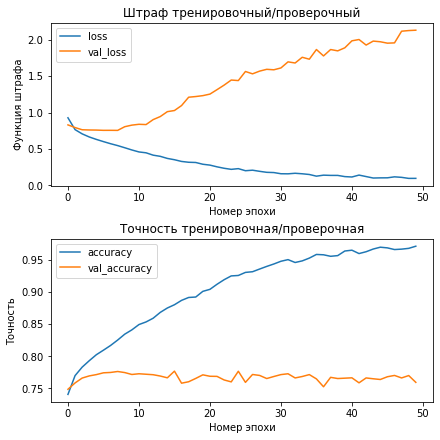

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(myhistory.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(myhistory.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

In [92]:
from datetime import datetime
import pickle

tests_acc = []
for k in range(len(params_s_f)):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    start_time = time.time()
    print('Подготовка данных...')
    spectr = None
    train_ = None
    val_ = None
    test_ = None
    input_shape = None
    spectr = preprocess_dataset(train_files,params_s_f[k][0],params_s_f[k][1])
    train_=spectr
    val_ = preprocess_dataset(val_files,params_s_f[k][0],params_s_f[k][1])
    test_ = preprocess_dataset(test_files,params_s_f[k][0],params_s_f[k][1])
    for spectrogram, _ in spectr.take(1):
        input_shape = spectrogram.shape
    print('Размер входных данных: ', input_shape)
    train_ = train_.batch(batch_size)
    train_ = train_.cache().prefetch(AUTOTUNE)
    val_ = val_.batch(batch_size)
    val_ = val_.cache().prefetch(AUTOTUNE)
    
    test_audio = []
    test_labels = []
    for audio, label in test_:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())
    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)
    
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    mymodel = create_model(input_shape)
    print('Обучение...') 
    start_time = time.time()
    myhistory = mymodel.fit(train_, validation_data=val_, epochs=EPOCHS, verbose=0,
                            callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
    y_true = test_labels
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    
    mymodel.save(f"model_fstsf_{k}.h5")
    
    with open(f'./history_fstsf_{k}_epoch.data', 'wb') as filehandle:
        # сохраняем данные как двоичный поток
        pickle.dump(myhistory.epoch, filehandle)

    with open(f'./history_fstsf_{k}_history.data', 'wb') as filehandle:
        # сохраняем данные как двоичный поток
        pickle.dump(myhistory.history, filehandle)



---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  5
2022-06-09 13:51:30
Подготовка данных...
Размер входных данных:  (5, 83)
--- 0.0 минут 6.739671468734741 секунд ---
Обучение...
--- 1.0 минут 34.687068700790405 секунд ---
85/85 [==============================] - 0s 5ms/step
Шаг: 256 , количество спектрограмм:  5 , accuracy тестовой выборки:  92.0 %
---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  10
2022-06-09 13:53:12
Подготовка данных...
Размер входных данных:  (10, 83)
--- 0.0 минут 6.7205212116241455 секунд ---
Обучение...
--- 1.0 минут 39.25848841667175 секунд ---
85/85 [==============================] - 0s 5ms/step
Шаг: 256 , количество спектрограмм:  10 , accuracy тестовой выборки:  92.4074074074074 %
---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  15
2022-06-09 13:54:59
Подготовка данных...
Размер входных

Размер входных данных:  (10, 83)
--- 0.0 минут 2.0644683837890625 секунд ---
Обучение...
--- 0.0 минут 43.507362604141235 секунд ---
85/85 [==============================] - 0s 3ms/step
Шаг: 2048 , количество спектрограмм:  10 , accuracy тестовой выборки:  95.55555555555556 %
---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  15
2022-06-09 14:17:12
Подготовка данных...
Размер входных данных:  (15, 83)
--- 0.0 минут 2.1164791584014893 секунд ---
Обучение...
--- 0.0 минут 48.518932819366455 секунд ---
85/85 [==============================] - 0s 3ms/step
Шаг: 2048 , количество спектрограмм:  15 , accuracy тестовой выборки:  95.85185185185185 %
---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  20
2022-06-09 14:18:03
Подготовка данных...
Размер входных данных:  (20, 83)
--- 0.0 минут 2.260512590408325 секунд ---
Обучение...
--- 0.0 минут 51.187851667404175 секунд ---
85/85 [===

In [93]:
spectr = None
train_ = None
val_ = None
test_ = None
input_shape = None
test_audio = None
test_labels = None
myhistory = None
mymodel = None

In [94]:
np.array(tests_acc)

array([92.        , 92.40740741, 94.37037037, 95.48148148, 94.7037037 ,
       95.14814815, 92.92592593, 94.96296296, 95.03703704, 95.48148148,
       95.        , 95.7037037 , 95.59259259, 95.55555556, 95.        ,
       95.66666667, 95.7037037 , 95.55555556, 94.96296296, 95.55555556,
       95.85185185, 95.59259259, 96.14814815, 95.81481481, 95.55555556,
       95.48148148, 95.03703704, 94.25925926, 95.18518519, 95.48148148,
       93.33333333, 93.77777778, 94.14814815, 94.        , 93.81481481,
       93.07407407])

Text(51.0, 0.5, 'Шаг')

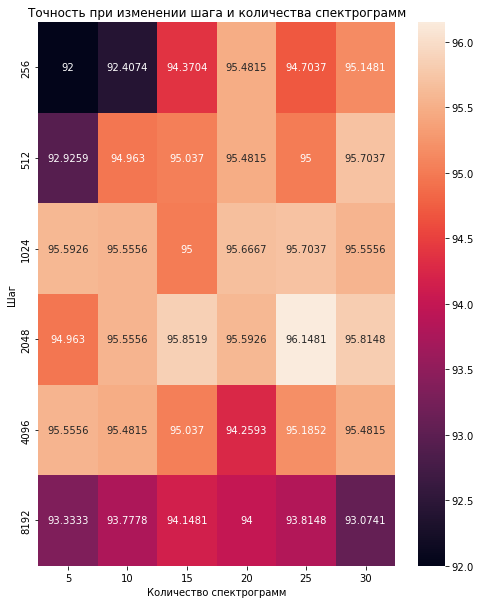

In [95]:
test_acc_mtx = np.zeros((len(step),len(num_frame)))
p = 0
for s in range(len(step)):
    for f in range(len(num_frame)):
        test_acc_mtx[s][f] = tests_acc[p]
        p+=1
plt.figure(figsize=(8, 10))
sns.heatmap(test_acc_mtx, xticklabels=num_frame, yticklabels=step, 
            annot=True, fmt='g')
plt.title('Точность при изменении шага и количества спектрограмм')
plt.xlabel('Количество спектрограмм')
plt.ylabel('Шаг')

In [96]:
for k in range(len(params_s_f)):
    print(k, params_s_f[k],tests_acc[k])

0 (256, 5) 92.0
1 (256, 10) 92.4074074074074
2 (256, 15) 94.37037037037037
3 (256, 20) 95.48148148148148
4 (256, 25) 94.7037037037037
5 (256, 30) 95.14814814814815
6 (512, 5) 92.92592592592592
7 (512, 10) 94.96296296296296
8 (512, 15) 95.03703703703704
9 (512, 20) 95.48148148148148
10 (512, 25) 95.0
11 (512, 30) 95.7037037037037
12 (1024, 5) 95.5925925925926
13 (1024, 10) 95.55555555555556
14 (1024, 15) 95.0
15 (1024, 20) 95.66666666666667
16 (1024, 25) 95.7037037037037
17 (1024, 30) 95.55555555555556
18 (2048, 5) 94.96296296296296
19 (2048, 10) 95.55555555555556
20 (2048, 15) 95.85185185185185
21 (2048, 20) 95.5925925925926
22 (2048, 25) 96.14814814814815
23 (2048, 30) 95.81481481481482
24 (4096, 5) 95.55555555555556
25 (4096, 10) 95.48148148148148
26 (4096, 15) 95.03703703703704
27 (4096, 20) 94.25925925925925
28 (4096, 25) 95.18518518518519
29 (4096, 30) 95.48148148148148
30 (8192, 5) 93.33333333333333
31 (8192, 10) 93.77777777777779
32 (8192, 15) 94.14814814814815
33 (8192, 20) 94.

In [97]:
k_max = np.argmax(np.array(tests_acc))
k_max

22

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная для шага 2048 и 25 спектрограмм')]

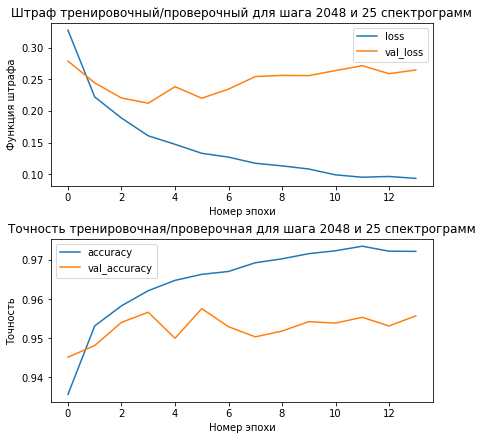

In [98]:
#for k in range(len(params_s_f)):
#for k in range(2):
k = k_max
with open(f'./history_fstsf_{k}_epoch.data', 'rb') as f:
    h_epoch = pickle.load(f)
with open(f'./history_fstsf_{k}_history.data', 'rb') as f:
    h_history = pickle.load(f)
#metrics = histories[k].history
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(h_epoch, h_history['loss'], h_history['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для шага {params_s_f[k][0]} и {params_s_f[k][1]} спектрограмм')

axes[1].plot(h_epoch, h_history['accuracy'], h_history['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для шага {params_s_f[k][0]} и {params_s_f[k][1]} спектрограмм')

In [99]:
params_s_f[k_max][0],params_s_f[k_max][1]

(2048, 25)

In [100]:
from tensorflow.keras.models import load_model
train_ds = []
val_ds = []
test_ds = []

spectrogram_ds = preprocess_dataset(train_files,params_s_f[k_max][0],params_s_f[k_max][1])
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files,params_s_f[k_max][0],params_s_f[k_max][1])
test_ds = preprocess_dataset(test_files,params_s_f[k_max][0],params_s_f[k_max][1])

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

model_ = load_model(f"model_fstsf_{k_max}.h5")

y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100
test_acc

85/85 [==============================] - 0s 3ms/step


96.14814814814815

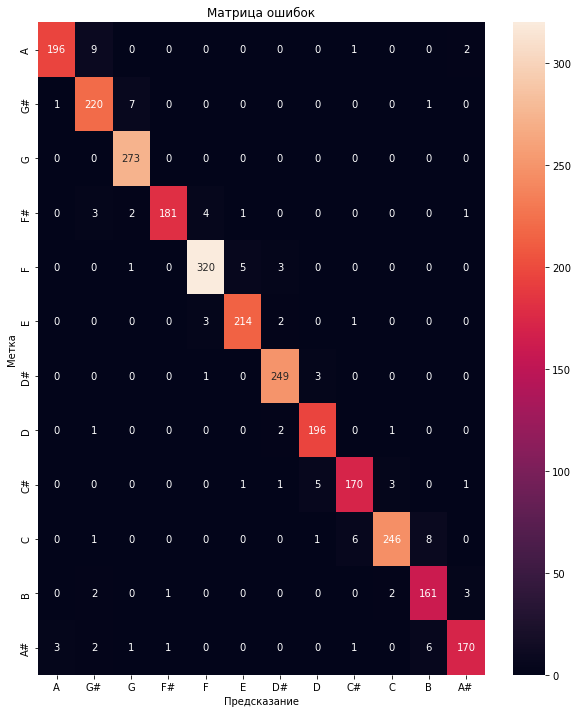

In [101]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

Sample file: D:\magistracy\diplom\records_cut\E\arpeg-CMaj-060BPM-leg_2.wav


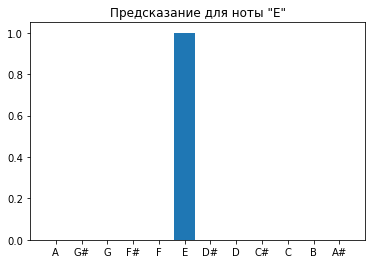

1


In [102]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', sample_file)

sample_ds = preprocess_dataset([str(sample_file)],params_s_f[k_max][0],params_s_f[k_max][1])
count = 0 
for spectrogram, label in sample_ds.batch(1):
    count+=1
    prediction = model_(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Предсказание для ноты "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()
print(count)

In [103]:
# Сохраняем модель
model_.save(r"D:\magistracy\diplom\model\model_fstft_new.h5")

In [104]:
model_.summary()

Model: "model_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 25, 83)]          0         
                                                                 
 flatten_136 (Flatten)       (None, 2075)              0         
                                                                 
 relu_1 (Dense)              (None, 512)               1062912   
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 1,594,380
Trainable params: 1,594,380
Non-t

C:\Users\belas\AppData\Local\Temp/ipykernel_5784/3168724974.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


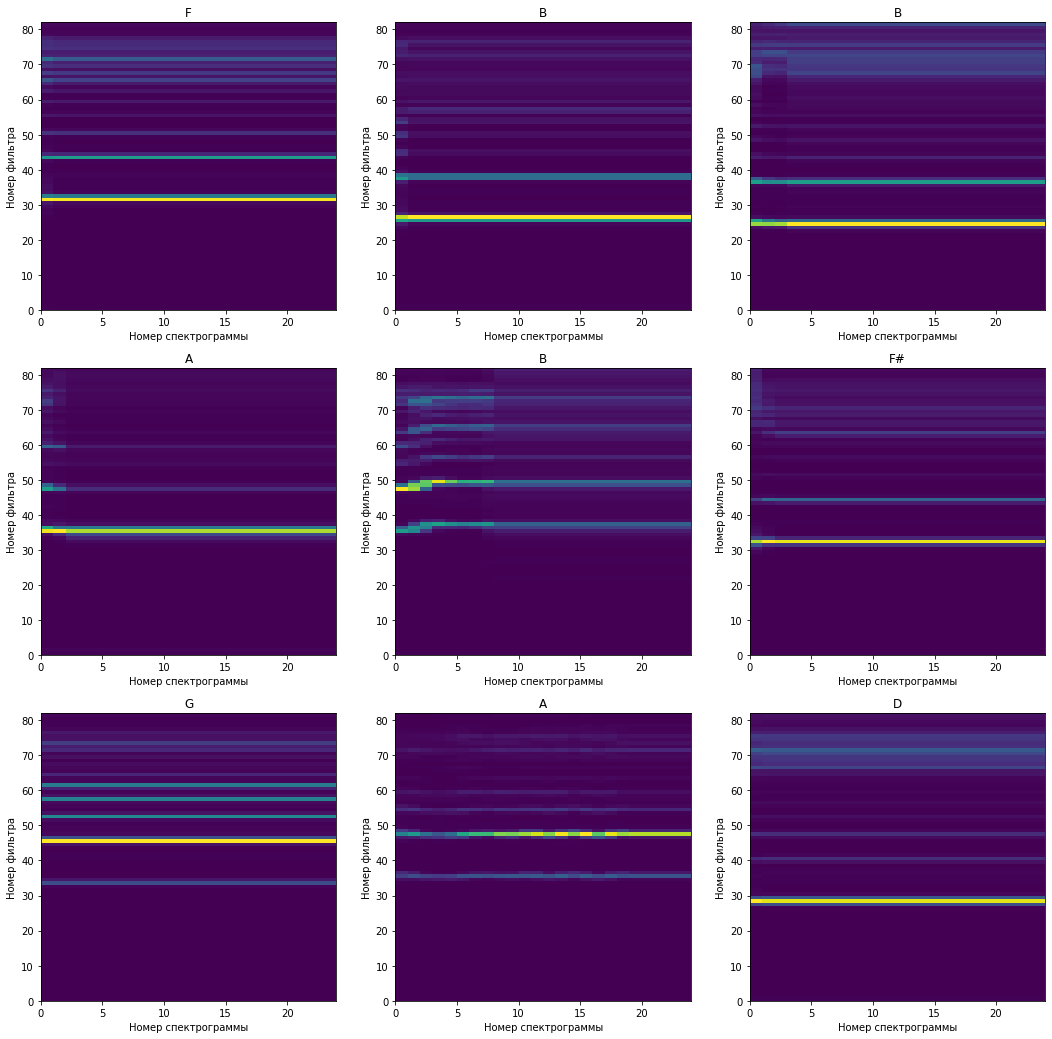

In [105]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
#for i, (spectrogram, label_id) in enumerate(spectr.take(n)):
    r = i // cols
    c = i % cols
    
    plot_spectrogram(np.squeeze(spectrogram.numpy()), axes[r][c])
    axes[r][c].set_title(notes[label_id.numpy()])
    axes[r][c].set_xlabel('Номер спектрограммы')
    axes[r][c].set_ylabel('Номер фильтра')


plt.show()

__________________________________

In [106]:
EPOCHS = 50

for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    print('input_shape',input_shape)

input_shape (25, 83)


In [107]:
print('---------------------------------------------------------------------')
print('Шаг:', params_s_f[k_max][0], ', количество спектрограмм: ',params_s_f[k_max][1])
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

mymodel = create_model(input_shape)

start_time = time.time()
myhistory = mymodel.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1)
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100

print('Шаг:', params_s_f[k_max][0], ', количество спектрограмм: ',params_s_f[k_max][1], ', accuracy тестовой выборки: ', test_acc, '%')

---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  25
2022-06-09 14:30:39
Epoch 1/50
296/296 [==============================] - 16s 53ms/step - loss: 0.3296 - accuracy: 0.9359 - val_loss: 0.2704 - val_accuracy: 0.9469
Epoch 2/50
296/296 [==============================] - 3s 9ms/step - loss: 0.2206 - accuracy: 0.9524 - val_loss: 0.2586 - val_accuracy: 0.9456
Epoch 3/50
296/296 [==============================] - 3s 9ms/step - loss: 0.1890 - accuracy: 0.9581 - val_loss: 0.2213 - val_accuracy: 0.9541
Epoch 4/50
296/296 [==============================] - 3s 9ms/step - loss: 0.1599 - accuracy: 0.9618 - val_loss: 0.2324 - val_accuracy: 0.9511
Epoch 5/50
296/296 [==============================] - 3s 9ms/step - loss: 0.1457 - accuracy: 0.9640 - val_loss: 0.2204 - val_accuracy: 0.9539
Epoch 6/50
296/296 [==============================] - 3s 9ms/step - loss: 0.1396 - accuracy: 0.9661 - val_loss: 0.2365 - val_accuracy: 0.9517
Epoch 7/50
296/

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная для для шага 2048 и 25 спектрограмм на 50 эпохах')]

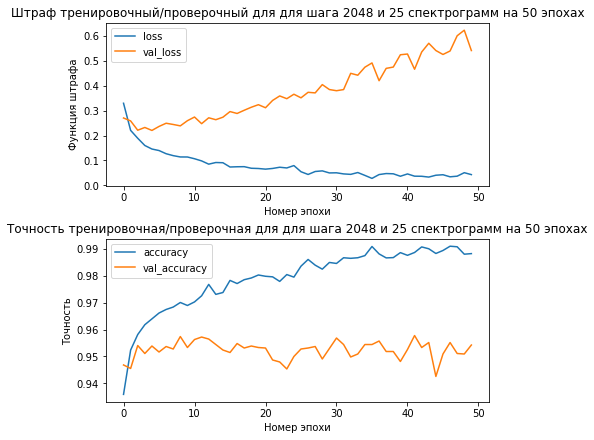

In [108]:
metrics = myhistory.history
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(myhistory.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для для шага {params_s_f[k][0]} и {params_s_f[k][1]} спектрограмм на 50 эпохах')

axes[1].plot(myhistory.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для для шага {params_s_f[k][0]} и {params_s_f[k][1]} спектрограмм на 50 эпохах')

In [ ]:
model_=None